# 基于LSTM模型的用电量预测
利用时间跨度为1年，分辨率1h的负荷数据进行比较粗糙的日前预测，主要目的是过一遍基本流程
***
#### 调用常用库

pandas处理原始CSV数据和异常值

numpy进行数值计算和数组转换

sklearn标准化数据和划分数据集

torch创建数据加载器和训练预测模型

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import StandardScaler

#### 读取数据，处理异常数据

In [2]:
df=pd.read_csv('白兔F1.csv',skiprows=1,header=None,names=['timestamp','load'],encoding='gbk')#读取数据，跳过第一行，将第二行作为列名，且注意读取中文需加gbk编码
df['timestamp']=pd.to_datetime(df['timestamp'])
df=df.set_index('timestamp')
df

,load
timestamp,
2015-01-01 00:00:00,53.96
2015-01-01 01:00:00,47.12
2015-01-01 02:00:00,42.72
2015-01-01 03:00:00,37.44
2015-01-01 04:00:00,36.40
...,...
2015-12-31 20:00:00,76.40
2015-12-31 21:00:00,69.84
2015-12-31 22:00:00,60.71


In [3]:
df['load']=pd.to_numeric(df['load'],errors='coerce')#将load列转为数值型，遇到无法转换的值则赋值为NaN
df['load']=np.where((df['load']<10)|(df['load']>200)|(df['load']==0),np.nan,df['load'])#格式：np.where(condition, value_if_true, value_if_false)
df['load']=df['load'].interpolate(method='linear')#时间序列常用线性插值处理异常值

#### 构建dataloader

In [4]:
#划分数据集：6:2:2
total_len=len(df)
train_len=int(total_len*0.6)
val_len=int(total_len*0.2)
test_len=total_len-train_len-val_len
train_df=df.iloc[:train_len]
val_df=df.iloc[train_len:train_len+val_len]
test_df=df.iloc[train_len+val_len:]

In [5]:
#标准化数据，scaler.fit_transform()函数用于计算训练数据的均值和标准差，并使用这些统计量来标准化训练数据
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df)
val_scaled = scaler.transform(val_df)#注意为避免数据泄露，应用训练集的均值和标准差训练，所以不用fit
test_scaled = scaler.transform(test_df)

Dataset包含所有样本，样本数目为len的大小，每个样本由x和y组成，x为输入，y为输出，大小分别对应window_size和horizon，其中x为window_size个连续时刻的load值，y为horizon个连续时刻的load值

In [6]:
class   TimeSeriesDataset(Dataset):
    def __init__(self,data,window_size=72,horizon=24):
        self.data=data
        self.window_size=window_size
        self.horizon=horizon
    def __len__(self):
        return len(self.data)-self.window_size-self.horizon+1
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.window_size]
        y = self.data[idx+self.window_size:idx+self.window_size+self.horizon]
        return torch.tensor(x).float(), torch.tensor(y).float().squeeze(-1)  # x仍为(72,1)y形状变为(24,)

In [7]:
train_dataset= TimeSeriesDataset(train_scaled,window_size=72,horizon=24)
val_dataset= TimeSeriesDataset(val_scaled,window_size=72,horizon=24)
test_dataset= TimeSeriesDataset(test_scaled,window_size=72,horizon=24)

batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)#从dataset中随机拿出来32个样本，其中x的维度：(32,72,1)，y的维度：(32,24)，始终遵循PyTorch的(batch, seq, feature)维度约定，batch[0]表示x，batch[1]表示y
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### 检查数据集和加载器
第一次写代码时遇到维度不匹配问题，这一部分是调试所用

In [8]:
# 检查第一个batch的维度
first_batch = next(iter(train_loader))
print(f"x shape: {first_batch[0].shape}")  # 应输出 torch.Size([32,72,1])
print(f"y shape: {first_batch[1].shape}")  # 应输出 torch.Size([32,24])

# 检查数据内容示例
print("示例x[0]:", first_batch[0][0])  # 第一个样本的72小时历史
print("对应y[0]:", first_batch[1][0])  # 对应的24小时真值

x shape: torch.Size([32, 72, 1])
y shape: torch.Size([32, 24])
示例x[0]: tensor([[-0.7763],
        [-0.9614],
        [-1.0259],
        [-1.4193],
        [-1.4193],
        [-0.8301],
        [ 0.1547],
        [ 0.5225],
        [ 0.7205],
        [ 0.7976],
        [ 1.6515],
        [ 1.2322],
        [ 0.8106],
        [ 1.2582],
        [ 1.3097],
        [ 1.1139],
        [ 1.1524],
        [ 0.9696],
        [ 1.2452],
        [ 1.4947],
        [ 1.3375],
        [ 0.8903],
        [ 0.9956],
        [ 0.2989],
        [-0.1204],
        [-0.1720],
        [-0.5013],
        [-0.7378],
        [-0.7893],
        [-0.5528],
        [ 0.2599],
        [ 0.6538],
        [ 0.9956],
        [ 1.5592],
        [ 1.8621],
        [ 0.9826],
        [ 1.6130],
        [ 1.5073],
        [ 1.2452],
        [ 1.4817],
        [ 1.5332],
        [ 1.2707],
        [ 1.3634],
        [ 1.4409],
        [ 1.4280],
        [ 1.5073],
        [ 1.3097],
        [ 0.8388],
        [ 0.1417]

#### 构建模型
![jupyter](./deepseek_mermaid_20250629_5bde39.png)
LSTM提取特征，FC进行解码

In [9]:
import torch.optim as optim
from tqdm import tqdm
class LSTMForecaster(nn.Module):#基于LSTM的时间序列预测模型
    def __init__(self, input_dim=1, hidden_dim=128, num_layers=2, output_dim=24):#input_dim: 输入特征的维度，表示只有时间单一变量；hidden_dim: LSTM隐藏层的维度，表示神经元数量；num_layers: LSTM的层数，注意是隐藏层；output_dim: 输出特征的维度，表示预测24小时。注意输入强制是三维张量
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,# 输入和输出张量的形状为(batch_size, seq_len, feature_size)
            dropout=0.2 if num_layers > 1 else 0#, dropout: LSTM层之间的dropout概率，用于防止过拟合
        )
        #全连接层
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),#线性变换128->64
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
         # [B, T] -> [B, T, 1]
        output, _ = self.lstm(x)  # [B, T, H]
        last_output = output[:, -1, :]  # 历史序列的结尾状态代表全局信息（最后一步已经融入前面的信息），所以只取最后一个时间步（共72小时）的输出，最后1小时的[32,128]
        return self.fc(last_output)  # [B, output_dim]

# ========== 初始化模型 ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMForecaster(
    input_dim=1,
    hidden_dim=128,
    num_layers=2,
    output_dim=24  # 关键：设置为预测长度24
).to(device)

In [10]:

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)#优化器,用于改变训练参数。weight_decay=1e-5表示正则化项的权重衰减系数,用于防止过拟合,lr=0.001表示初始学习率
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)#负责调整学习率，mode='min'表示当验证集损失不再下降时，减小学习率,factor=0.5表示学习率减半，patience=3表示在验证集损失不再下降时等待3个epoch再调整学习率,verbose=True表示在调整学习率时打印日志

F:\anoconda\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


![jupyter](./deepseek_mermaid_20250629_7aa17d.png)

In [11]:
#一个完整的训练epoch
def train_epoch(model, loader):
    model.train()#模型切换为训练模式
    total_loss = 0
    for x, y in tqdm(loader, desc="Training"):#遍历loader的每一个batch,每一个batch就蕴含x和y两个变量，均已知
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()#梯度清零
        outputs = model(x)#前向传播，输出一个预测值
        loss = criterion(outputs, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # 梯度裁剪
        optimizer.step()#更新参数

        total_loss += loss.item() * x.size(0)#因为loss是平均loss，所以需要乘以batch size，得到总loss
    return total_loss / len(loader.dataset)

In [12]:
#一个完整的验证epoch
def validate(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():#验证，不需要计算梯度
        for x, y in tqdm(loader, desc="Validating"):
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

#### 开始训练

In [13]:
best_val_loss = float('inf')
patience, patience_counter = 10, 0

for epoch in range(1, 51):
    print(f"\nEpoch {epoch}/50")
    train_loss = train_epoch(model, train_loader)
    val_loss = validate(model, val_loader)
    scheduler.step(val_loss)

    print(f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    # 早停机制，避免过拟合
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break


Epoch 1/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 294.52it/s]


Train Loss: 0.548801 | Val Loss: 0.207993
Saved best model!

Epoch 2/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 360.72it/s]


Train Loss: 0.272870 | Val Loss: 0.185678
Saved best model!

Epoch 3/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 508.25it/s]


Train Loss: 0.248239 | Val Loss: 0.187566

Epoch 4/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 394.35it/s]


Train Loss: 0.243293 | Val Loss: 0.174058
Saved best model!

Epoch 5/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 357.63it/s]


Train Loss: 0.233137 | Val Loss: 0.168495
Saved best model!

Epoch 6/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 424.27it/s]


Train Loss: 0.229797 | Val Loss: 0.182164

Epoch 7/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 441.44it/s]


Train Loss: 0.224310 | Val Loss: 0.182253

Epoch 8/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 422.63it/s]


Train Loss: 0.222800 | Val Loss: 0.170153

Epoch 9/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 439.30it/s]


Train Loss: 0.219537 | Val Loss: 0.181207

Epoch 10/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 434.58it/s]


Train Loss: 0.207979 | Val Loss: 0.179725

Epoch 11/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 370.95it/s]


Train Loss: 0.202709 | Val Loss: 0.168194
Saved best model!

Epoch 12/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 393.96it/s]


Train Loss: 0.201204 | Val Loss: 0.174731

Epoch 13/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 424.37it/s]


Train Loss: 0.200504 | Val Loss: 0.164027
Saved best model!

Epoch 14/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 479.56it/s]


Train Loss: 0.195823 | Val Loss: 0.178797

Epoch 15/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 473.46it/s]


Train Loss: 0.193809 | Val Loss: 0.161610
Saved best model!

Epoch 16/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 407.22it/s]


Train Loss: 0.192659 | Val Loss: 0.171266

Epoch 17/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 499.20it/s]


Train Loss: 0.187440 | Val Loss: 0.164304

Epoch 18/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 474.56it/s]


Train Loss: 0.188134 | Val Loss: 0.168269

Epoch 19/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 499.76it/s]


Train Loss: 0.186893 | Val Loss: 0.162816

Epoch 20/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 493.08it/s]


Train Loss: 0.174707 | Val Loss: 0.167739

Epoch 21/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 504.67it/s]


Train Loss: 0.175450 | Val Loss: 0.159430
Saved best model!

Epoch 22/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 495.50it/s]


Train Loss: 0.173321 | Val Loss: 0.155678
Saved best model!

Epoch 23/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 505.98it/s]


Train Loss: 0.171321 | Val Loss: 0.163515

Epoch 24/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 485.84it/s]


Train Loss: 0.172552 | Val Loss: 0.162280

Epoch 25/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 502.32it/s]


Train Loss: 0.170326 | Val Loss: 0.161869

Epoch 26/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 476.19it/s]


Train Loss: 0.170070 | Val Loss: 0.158217

Epoch 27/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 491.16it/s]


Train Loss: 0.166210 | Val Loss: 0.161522

Epoch 28/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 498.18it/s]


Train Loss: 0.165438 | Val Loss: 0.158345

Epoch 29/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 493.39it/s]


Train Loss: 0.166126 | Val Loss: 0.159983

Epoch 30/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 495.03it/s]


Train Loss: 0.164866 | Val Loss: 0.161858

Epoch 31/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 472.83it/s]


Train Loss: 0.161650 | Val Loss: 0.156272

Epoch 32/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 402.51it/s]


Train Loss: 0.161609 | Val Loss: 0.155460
Saved best model!

Epoch 33/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 463.95it/s]


Train Loss: 0.161144 | Val Loss: 0.155847

Epoch 34/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 509.52it/s]


Train Loss: 0.160942 | Val Loss: 0.157436

Epoch 35/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 509.40it/s]


Train Loss: 0.160513 | Val Loss: 0.159325

Epoch 36/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 492.31it/s]


Train Loss: 0.157847 | Val Loss: 0.158871

Epoch 37/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 457.07it/s]


Train Loss: 0.155825 | Val Loss: 0.157351

Epoch 38/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 516.64it/s]


Train Loss: 0.156457 | Val Loss: 0.158909

Epoch 39/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 507.86it/s]


Train Loss: 0.157505 | Val Loss: 0.159057

Epoch 40/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 499.31it/s]


Train Loss: 0.155763 | Val Loss: 0.159068

Epoch 41/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 496.81it/s]


Train Loss: 0.153491 | Val Loss: 0.159437

Epoch 42/50


Validating: 100%|██████████| 52/52 [00:00<00:00, 461.34it/s]

Train Loss: 0.153332 | Val Loss: 0.158347
Early stopping at epoch 42


#### 测试模型

In [14]:
model.load_state_dict(torch.load("best_model.pth"))#将最佳模型载入model
test_loss = validate(model, test_loader)
print(f"\nFinal Test Loss: {test_loss:.6f}")

# 反标准化后的测试损失计算
def inverse_transform_eval(model, loader, scaler):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)

            # 反标准化
            y_true = scaler.inverse_transform(y.cpu().numpy())
            y_pred = scaler.inverse_transform(outputs.cpu().numpy())

            # 计算原始尺度上的MSE
            loss = np.mean((y_true - y_pred)**2)
            total_loss += loss * x.size(0)
    return total_loss / len(loader.dataset)

test_loss_orig = inverse_transform_eval(model, test_loader, scaler)
print(f"Test Loss (Original Scale): {test_loss_orig:.4f}")

Validating: 100%|██████████| 52/52 [00:00<00:00, 481.17it/s]


Final Test Loss: 0.471807


Test Loss (Original Scale): 235.0462


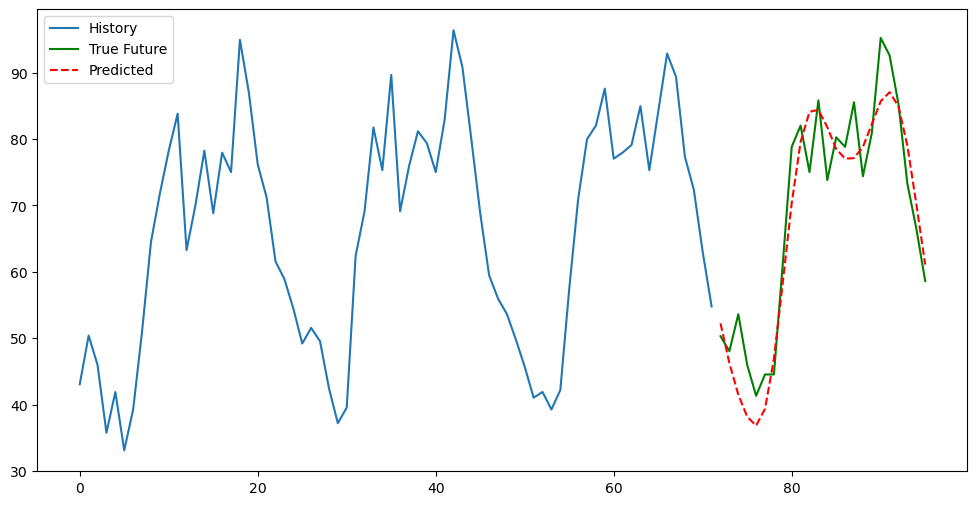

In [15]:
#可视化
import matplotlib.pyplot as plt
def plot_predictions(model, sample, scaler):
    model.eval()
    x, y_true = sample#等价于x=sample[0], y_true=sample[1]
    with torch.no_grad():
        y_pred = model(x.unsqueeze(0).to(device)).cpu()

    # 反标准化+
    x = scaler.inverse_transform(x.numpy().reshape(-1, 1)).flatten()
    y_true = scaler.inverse_transform(y_true.numpy().reshape(-1, 1)).flatten()
    y_pred = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1)).flatten()

    plt.figure(figsize=(12, 6))
    plt.plot(x, label='History')
    plt.plot(range(len(x), len(x)+len(y_true)), y_true, 'g-', label='True Future')

    plt.plot(range(len(x), len(x)+len(y_pred)), y_pred, 'r--', label='Predicted')
    plt.legend()
    plt.show()

# 使用测试集第一个样本
plot_predictions(model, test_dataset[0], scaler)

C:\Users\OMEN\AppData\Local\Temp\ipykernel_31212\4183742339.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_hours = pd.date_range(


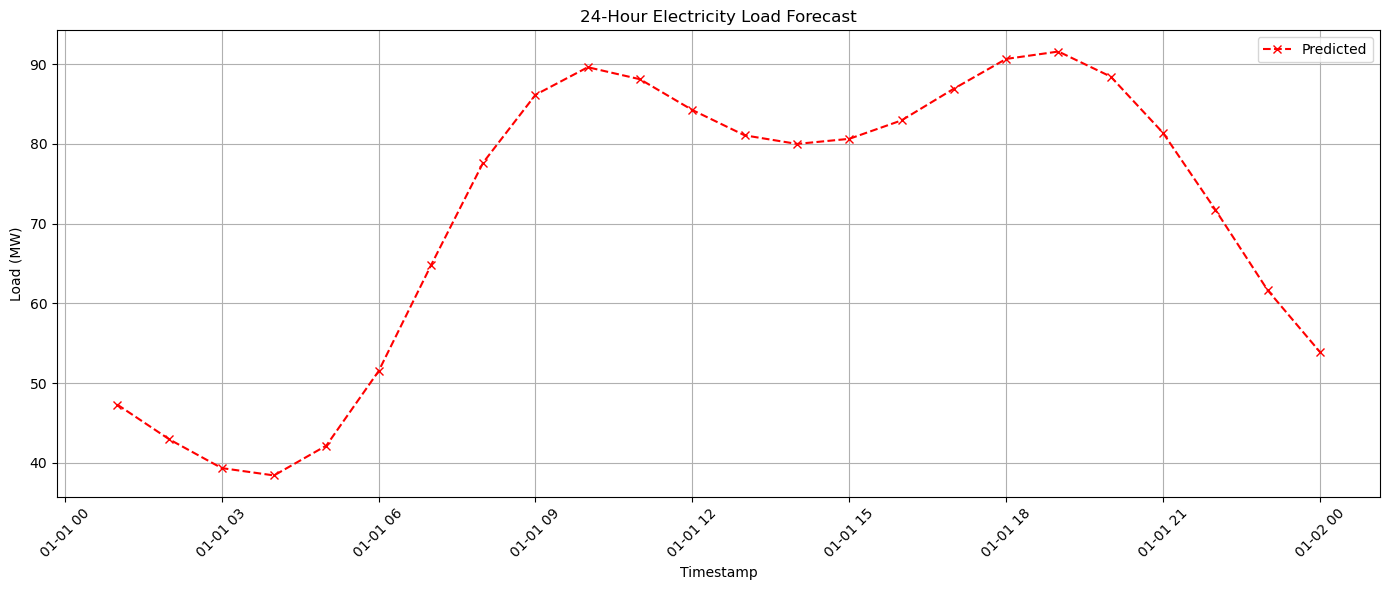

             timestamp  predicted_load
0  2016-01-01 01:00:00           47.31
1  2016-01-01 02:00:00           42.94
2  2016-01-01 03:00:00           39.34
3  2016-01-01 04:00:00           38.42
4  2016-01-01 05:00:00           42.16
5  2016-01-01 06:00:00           51.50
6  2016-01-01 07:00:00           64.74
7  2016-01-01 08:00:00           77.64
8  2016-01-01 09:00:00           86.14
9  2016-01-01 10:00:00           89.60
10 2016-01-01 11:00:00           88.09
11 2016-01-01 12:00:00           84.23
12 2016-01-01 13:00:00           81.06
13 2016-01-01 14:00:00           79.98
14 2016-01-01 15:00:00           80.62
15 2016-01-01 16:00:00           82.93
16 2016-01-01 17:00:00           86.90
17 2016-01-01 18:00:00           90.64
18 2016-01-01 19:00:00           91.56
19 2016-01-01 20:00:00           88.42
20 2016-01-01 21:00:00           81.37
21 2016-01-01 22:00:00           71.75
22 2016-01-01 23:00:00           61.65
23 2016-01-02 00:00:00           53.91


In [16]:
#进行真正的预测
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
last_idx=len(test_dataset)-1
x_last,y_last_true=test_dataset[last_idx]
x_last=x_last.unsqueeze(0).to(device)
with torch.no_grad():
    y_pred_scaled=model(x_last).cpu().numpy().squeeze()
# 6. 反标准化
# 将预测结果转换为二维数组进行反标准化
y_pred_scaled_2d = y_pred_scaled.reshape(-1, 1)#转化为一个列数为1的二维数组（-1表示行数自动推断）
y_pred = scaler.inverse_transform(y_pred_scaled_2d).flatten()#逆变换，flatten将二维数组转换为一维数组

# 8. 准备时间戳
last_timestamp = test_df.index[-1]
future_hours = pd.date_range(
    start=last_timestamp + pd.Timedelta(hours=1),
    periods=24,
    freq='H'
)

# 9. 可视化预测结果
plt.figure(figsize=(14, 6))
plt.plot(future_hours, y_pred, 'r--', label='Predicted', marker='x')
plt.title('24-Hour Electricity Load Forecast')
plt.xlabel('Timestamp')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 10. 输出预测结果表格
prediction_df = pd.DataFrame({
    'timestamp': future_hours,
    'predicted_load': y_pred.astype('float64').round(2)
})
print(prediction_df.round(2))
prediction_df.to_csv('prediction.csv', index=False)